In [1]:
%matplotlib inline
import underworld as uw
import math
from underworld import function as fn
import glucifer
import matplotlib.pyplot as pyplot
import numpy as np


In [2]:
dim = 2
meshX = 64
meshY = 64

Q1dP0Mesh = uw.mesh.FeMesh_Cartesian( elementType='Q1/dQ0',
                                      elementRes=(meshX,meshY), 
                                      minCoord=(0.,0.), maxCoord=(1.0,1.0)  )

Q1Mesh =  Q1dP0Mesh # returns outer mesh by default
dP0Mesh = Q1dP0Mesh.subMesh

velocityMesh =  Q1Mesh
pressureMesh = dP0Mesh

xCoordFn = fn.input()[0]
yCoordFn = fn.input()[1]

In [169]:
# create & zero meshvariables
velocityField    = uw.mesh.MeshVariable( mesh=velocityMesh,   nodeDofCount=dim )
pressureField    = uw.mesh.MeshVariable( mesh=pressureMesh,   nodeDofCount=1 )
temperatureField = uw.mesh.MeshVariable( mesh=velocityMesh,   nodeDofCount=1 )

velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.
temperatureField.data[:] = 0

In [170]:
IWalls = velocityMesh.specialSets["MinI_VertexSet"] + velocityMesh.specialSets["MaxI_VertexSet"]
JWalls = velocityMesh.specialSets["MinJ_VertexSet"] + velocityMesh.specialSets["MaxJ_VertexSet"]

freeslipBC = uw.conditions.DirichletCondition(    variable=velocityField, 
                                                  indexSetsPerDof=(IWalls,JWalls) )

# temperature does not evolve with time so no bcs are needed

In [171]:
import numpy as np
import math

def gauss(r,a):
   return np.exp(-r**2/a**2) 

def three_way_node_density(alpha, beta, yLoc):
    """
    This is a function to return a new distribution of point densities on the unit interval
    in three gaussian-shaped regions (surface, base and one specified - 
    presumed to be where the forcing function is concentrated)
    
    """

    count = len(yLoc)
    new_vpoints            = np.zeros(count)

    refine1 = gauss(yLoc, beta) 
    refine2 = gauss(yLoc-1.0, beta)
    refine3 = gauss(yLoc-alpha, beta)

    node_density_function = (refine1 + refine2 + refine3)
                
    return node_density_function


def unit_interval_node_spacer(node_count, separation, yd):

    from scipy import interpolate as interpolate
    from scipy.misc import derivative as derivative

    count = node_count

    ys = np.linspace(0.0,1.0,count)
    
    # separation = 10.0 * np.sin(4.0*math.pi*yd)**2
    separation -= separation.min() - 1.0
    separation_fn_rbf = interpolate.Rbf(yd, separation)
    separation_fn_rbf_deriv = derivative(separation_fn_rbf, ys, dx=0.5/count)

    sep = ys.copy() 
    sep[1:-1] = 0.5 * (ys[2:] - ys[0:-2])
    sep[-1] = sep[-2]
    sep[0] = sep[1]

    sep_ratio = sep / sep.min() 

    node_separation_anomaly = (sep_ratio - separation_fn_rbf(ys))
    node_separation_anomaly_rbf = interpolate.Rbf(ys, node_separation_anomaly, smooth=0.5)
    node_flux =  derivative(node_separation_anomaly_rbf, ys, dx=0.5/count)

    node_separation_anomaly0 = node_separation_anomaly.copy()

    delta = np.abs(sep / node_flux).min() / count
    residual = (node_separation_anomaly**2).sum()
    residual0 = residual
    loops = 0
    while loops < 1000 and residual > residual0 * 0.001:

        y_old = ys.copy()

        for i in range(1, count-1):
            ys += node_flux * delta  # ? SOR

        ys /= (ys.max() - ys.min()) 
        ys -= ys.min()

        ys = 0.75 * ys + 0.25 * y_old

        sep = ys.copy() 
        sep[1:-1] = 0.5 * (ys[2:] - ys[0:-2])
        sep[-1] = sep[-2]
        sep[0] = sep[1]

        sep_ratio = sep / sep.min() 

        node_separation_anomaly = (sep_ratio - separation_fn_rbf(ys))
        node_separation_anomaly_rbf = interpolate.Rbf(ys, node_separation_anomaly, smooth=0.5)
        node_flux = derivative(node_separation_anomaly_rbf, ys, dx=1.0/count)

        residual = (node_separation_anomaly**2).sum()

        delta = np.abs(sep / node_flux).min() / count
        loops += 1

#    print loops, "iterations, residual = ", residual / residual0
    
    return ys, sep_ratio


# Need to fix this for non-unit mesh sizes #

def remap_vmesh_pmesh_y(alpha, beta, intensity):
    """
    remap the mesh in x to give better resolution on boundaries and around one horizontal line
    """
    with velocityMesh.deform_mesh():
        yd = np.linspace(0,1.0,1000)
        separation = intensity * ( 1.0 - three_way_node_density(alpha, beta, yd)) 

        new_yVcoords, sep = unit_interval_node_spacer(meshY+1, separation, yd)

        vpoints = velocityMesh.data.reshape(meshY+1,meshX+1,2)

        meshMinY = velocityMesh.minCoord[1]
        meshDY =   velocityMesh.maxCoord[1] - velocityMesh.minCoord[1]

        for column in range(0,meshX+1):
            vpoints[:,column,1] = new_yVcoords[:] * meshDY + meshMinY

        # This will have changed the mesh since {v,p}points is a view into the original mesh data    

        actual_level = 0
        actual_coord = 0.0
        distance = 1.0

        for i in range(0,meshY+1):
            this_distance = np.abs(new_yVcoords[i] - alpha)
            if this_distance < distance:
                distance = this_distance
                actual_coord = new_yVcoords[i]
                actual_level = i

        return actual_coord, actual_level


def remap_vmesh_pmesh_x(alpha, beta, intensity):
    """
    remap the mesh in x to give better resolution on boundaries and around one vertical line.
    Caution, the kernel routines / ffts currently assume even spacing laterally !!
    """
    with velocityMesh.deform_mesh():

        xd = np.linspace(0,1.0,1000)
        separation = intensity * ( 1.0 - three_way_node_density(alpha, beta, xd)) 

        new_xVcoords, sep = unit_interval_node_spacer(meshX+1, separation, xd)

        vpoints = velocityMesh.data.reshape(meshY+1,meshX+1,2)

        meshMinX = velocityMesh.minCoord[0]
        meshDX =   velocityMesh.maxCoord[0] - velocityMesh.minCoord[0]

        for row in range(0,meshY+1):
            vpoints[row,:,0] = new_xVcoords[:] * meshDX + meshMinX

        # This will have changed the mesh since {v,p}points is a view into the original mesh data    

        actual_column = 0
        actual_coord = 0.0
        distance = 1.0

        for i in range(0,meshX+1):
            this_distance = np.abs(new_xVcoords[i] - alpha)
            if this_distance < distance:
                distance = this_distance
                actual_coord = new_xVcoords[i]
                actual_column = i

        return actual_coord, actual_column



[[ 0.79402221]
 [ 0.80293376]
 [ 0.81191327]]
0.802933764664 48



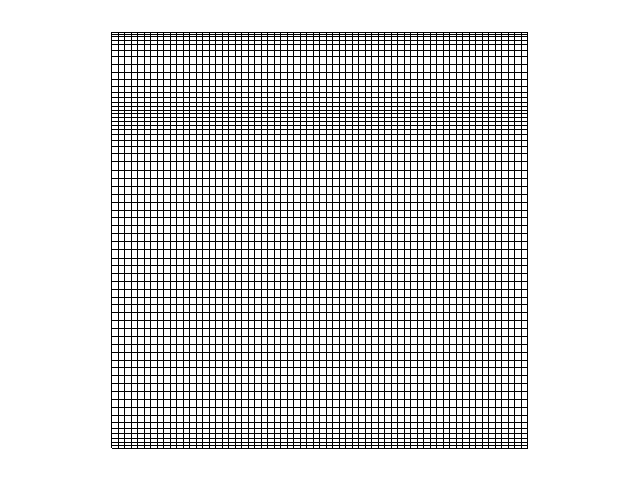

In [172]:

actual_y, layer  = remap_vmesh_pmesh_y(0.8,0.05, 2.0) 
#actual_x, column = remap_vmesh_pmesh_x(0.5,0.05,1.0) 

y_coordinates = yCoordFn.evaluate(velocityMesh.specialSets["MinI_VertexSet"])

print y_coordinates[[layer-1, layer, layer+1]]
print actual_y, layer

meshfig = glucifer.Figure()
meshfig.append( glucifer.objects.Mesh(velocityMesh))

meshfig.save_database('test.gldb')
meshfig.show()

In [3]:
meshfig = glucifer.Figure()
meshfig.append( glucifer.objects.Mesh(velocityMesh))

#meshfig.save_database('test.gldb')
meshfig.show()